In [43]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import math
import seaborn as sns

#from pandas_profiling import ProfileReport
# sklearn libraries
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

%matplotlib inline

In [25]:
data_files=os.listdir("../data/acea-water-prediction")
data=[]
for file in data_files:
    print(file)
    file_data=[]
    if "csv" in file:
        file_data=pd.read_csv("../data/acea-water-prediction/"+file,index_col="Date")
        if "River" in file:
            y=file_data.loc[:, file_data.columns.str.contains('Hydrometry')]
        elif "Aquifer" in file:
            if "Aquifer_Luco" in file:
                y=file_data.loc[:, file_data.columns.str.contains('Depth_to_Groundwater_Podere_Casetta')]
            else:
                y=file_data.loc[:, file_data.columns.str.contains('Depth_to_Groundwater')]
            
        elif "Lake" in file:
            y=file_data[["Lake_Level","Flow_Rate"]]
            
        elif "Water_Spring" in file:
            y=file_data.loc[:, file_data.columns.str.contains('Flow_Rate')]
        
        file_data=file_data.drop(y.columns,axis=1)      
        data.append([file_data,y,file])

River_Arno.csv
Aquifer_Luco.csv
Aquifer_Doganella.csv
Aquifer_Petrignano.csv
Water_Spring_Amiata.csv
Water_Spring_Lupa.csv
Water_Spring_Madonna_di_Canneto.csv
Lake_Bilancino.csv
Aquifer_Auser.csv
datasets_description.ods


Data separation early one to prevent data leakage

In [26]:
X_train,y_train=[],[]
X_test,y_test=[],[]
train_size=0.8
for i in range(len(data)):
    data[i][0]=data[i][0].loc[data[i][1].first_valid_index():data[i][1].last_valid_index()]
    data[i][1]=data[i][1].loc[data[i][1].first_valid_index():data[i][1].last_valid_index()]
                              
    data[i][1]=data[i][1].loc[data[i][0].first_valid_index():data[i][0].last_valid_index()]
    data[i][0]=data[i][0].loc[data[i][0].first_valid_index():data[i][0].last_valid_index()]
    for j in data[i][0].columns:
        if (data[i][0][j].isna().sum()/len(data[i][0][j]))>0.2:
            data[i][0].drop([j],axis=1,inplace=True)
                              
    data[i][1]=data[i][1].loc[data[i][0].first_valid_index():data[i][0].last_valid_index()]
    data[i][0]=data[i][0].loc[data[i][0].first_valid_index():data[i][0].last_valid_index()]
    
for trio in data:
    X_train.append(trio[0].iloc[0:np.int(np.floor(len(trio[0])*train_size)),:])
    X_test.append(trio[0].iloc[np.int(np.floor(len(trio[0])*train_size)):,:])
    y_train.append(trio[1].iloc[0:np.int(np.floor(len(trio[1])*train_size))])
    y_test.append(trio[1].iloc[np.int(np.floor(len(trio[1])*train_size)):])

## Data cleaning

For missing data with existing data before and after, we implement interpolation to replace the missing data. For missing data at the start of the sequence, we cut the missing data as it is a single block at the start of the sequence and represents, at least for the River Arno dataset, 1/3 of the available data. Replacing this data with inferred data would weigh the predictions with unexisting data.

In [27]:
for i in range(len(X_train)):
    X_train[i]=X_train[i].loc[y_train[i].first_valid_index():y_train[i].last_valid_index()]
    y_train[i]=y_train[i].loc[y_train[i].first_valid_index():y_train[i].last_valid_index()]
    X_train[i]=X_train[i].interpolate()
    X_train[i]=X_train[i].ffill()
    X_train[i]=X_train[i].bfill()
    X_train[i]=X_train[i].fillna(X_train[i].median())
    y_train[i]=y_train[i].interpolate()
    y_train[i]=y_train[i].ffill()
    y_train[i]=y_train[i].bfill()

for i in range(len(X_test)):
    
    X_test[i]=X_test[i].loc[y_test[i].first_valid_index():y_test[i].last_valid_index()]
    y_test[i]=y_test[i].loc[y_test[i].first_valid_index():y_test[i].last_valid_index()]
    X_test[i]=X_test[i][X_train[i].columns]
    X_test[i]=X_test[i].interpolate()
    X_test[i]=X_test[i].ffill()
    X_test[i]=X_test[i].bfill()
    X_test[i]=X_test[i].fillna(X_test[i].median())
    y_test[i]=y_test[i].interpolate()
    y_test[i]=y_test[i].ffill()
    y_test[i]=y_test[i].bfill()

## EDA

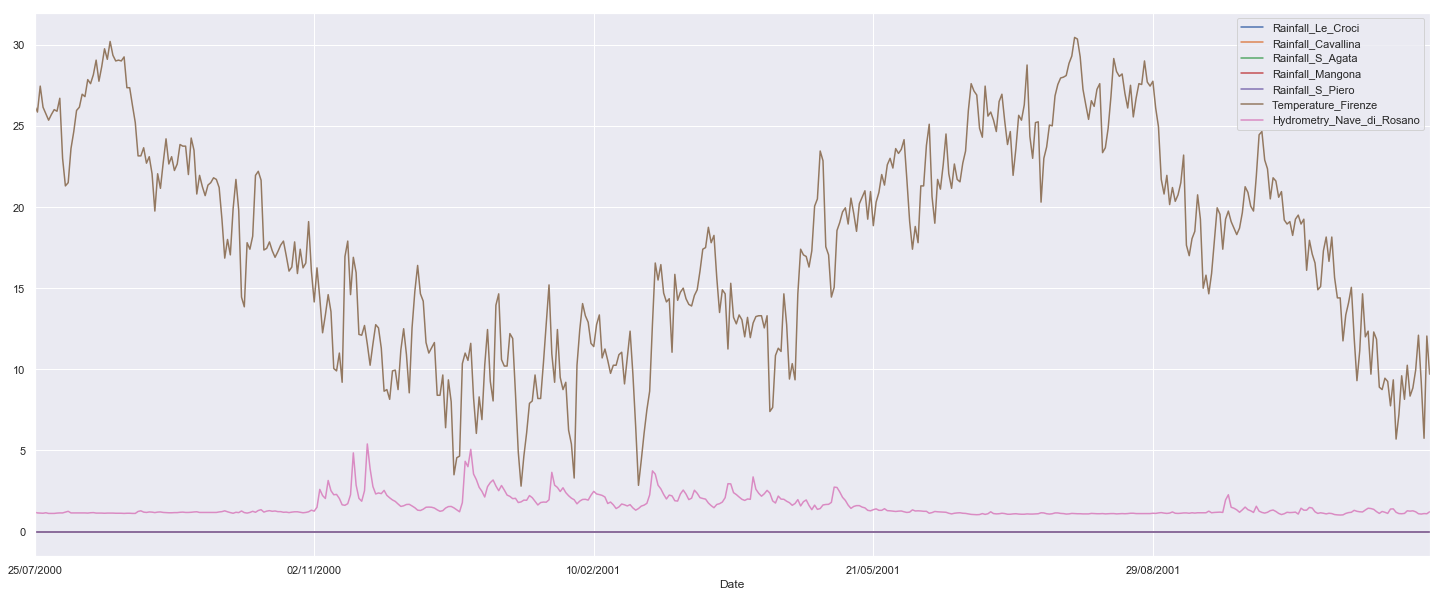

In [8]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(25, 10)})
nb_variables=X_train[0].columns
cols_plot = X_train[0].columns
axes = pd.concat([X_train[0][cols_plot].iloc[0:500],y_train[0].iloc[0:500]],axis=1).plot()

Feature scaling

In [9]:
mm_list=[]
X_train_sc=[]
for dataset in X_train:
    mm=MinMaxScaler()
    X_train_sc.append(pd.DataFrame(mm.fit_transform(dataset),columns=dataset.columns,index=dataset.index))
    mm_list.append(mm)

In [10]:
X_test_sc=[]
for i in range(len(X_test)):
    temp=mm_list[i].transform(X_test[i])
    X_test_sc.append(pd.DataFrame(temp,columns=X_test[i].columns,index=X_test[i].index))

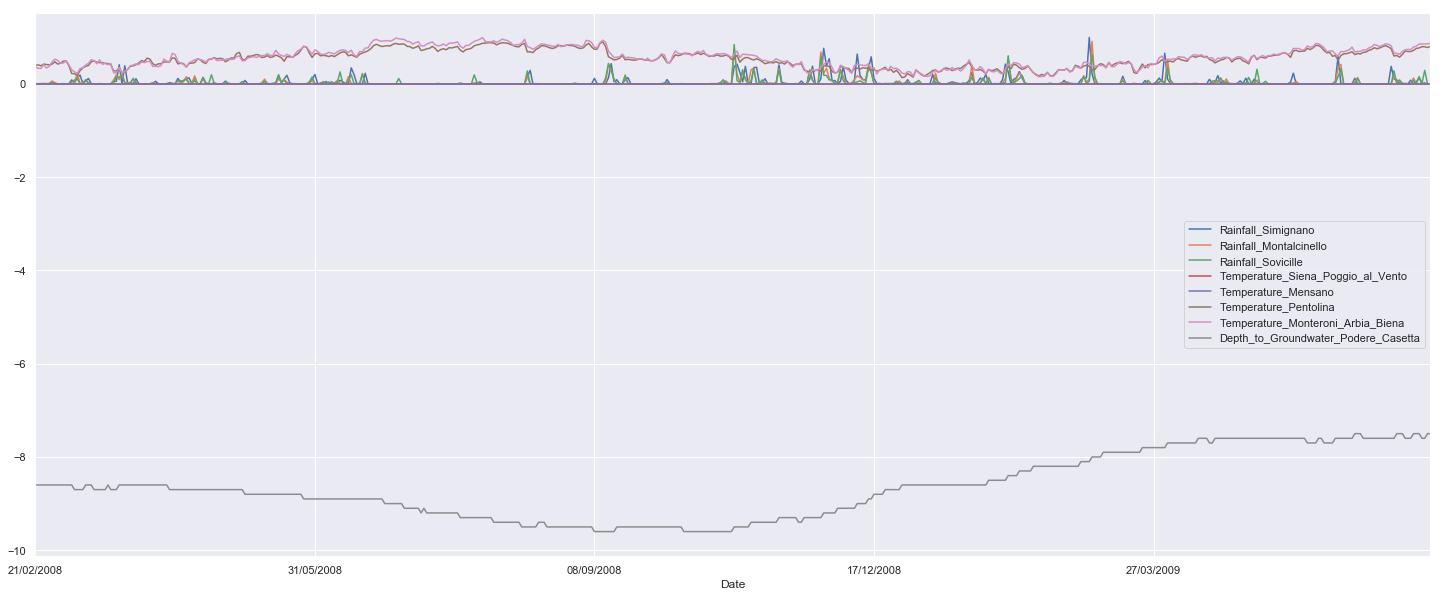

In [11]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(25, 10)})
nb_variables=X_train_sc[1].columns
cols_plot = X_train_sc[1].columns
axes = pd.concat([X_train_sc[1][cols_plot].iloc[0:500],y_train[1].iloc[0:500]],axis=1).plot()

## Feature engineering

WIP

## Models

0.43919130735734535
0.7134696409474259
0.823762951781899
-12.370108468143385


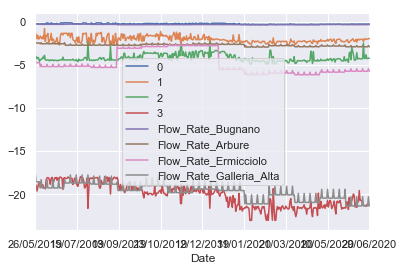

In [50]:
dataset_nb=4
knr= KNeighborsRegressor(n_neighbors=10)
knr.fit(X_train[dataset_nb],y_train[dataset_nb])
ypred_tr=knr.predict(X_train[dataset_nb])
print(mse(y_train[dataset_nb],ypred_tr))
print(r2(y_train[dataset_nb],ypred_tr))
ypred_te=knr.predict(X_test[dataset_nb])
print(mse(y_test[dataset_nb],ypred_te))
print(r2(y_test[dataset_nb],ypred_te))
pd.concat([pd.DataFrame(ypred_te,index=y_test[dataset_nb].index),y_test[dataset_nb]],axis=1).plot()